## SPACE-GM Tutorial

This tutorial demonstrates the workflow of SPACE-GM, which contains the following steps:

1. Construct cellular graphs with raw inputs
2. Construct `CellularGraphDataset` and attach node-level / graph-level tasks
3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
4. Train the GNN by randomly sampling subgraphs
5. Evaluate the GNN on node-level / graph-level tasks

In [2]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-geometric 2.3.1
Uninstalling torch-geometric-2.3.1:
  Successfully uninstalled torch-geometric-2.3.1
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu117/torch_scatter-2.1.1%2Bpt20cu117-cp310-cp310-linux_x86_64.whl (10.2 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu117/torch_sparse-0.6.17%2Bpt20cu117-cp310-cp310-linux_x86_64.whl (4.8 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu117/torch_cluster-1.6.1%2Bpt20cu117-cp310-cp310-linux_x86_64.whl (3.3 MB)
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-nd963ynt
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-nd963ynt
  Resolved https://github.com/pyg-team/pytorch_geom

In [4]:
import torch

torch.cuda.is_available()

False

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import spacegm

------------
### Step 1: Construct Cellular Graphs

We first construct cellular graphs as `networkx.Graph` using raw inputs including cell coordinates, cell types, biomarker expression, etc.

Raw files are assumed to be sorted in regions, each region should contain a spatially-continuous area of tissue and has all cells in the area identified and segmented.

For each region, we consider the following raw inputs:
- Cell coordinates stored in a csv file:
    - This file should contain at least two columns `X` and `Y` representing the 2D coordinates of cell centroids.
    - We highly recommend adding another column `CELL_ID` to match the rows with other raw inputs.
    - Example:
    | CELL_ID | X | Y |
    | --- | --- | --- |
    | 0 | 3 | 10 |
    | 1 | 25 | 12 |
    | 2 | 16 | 30 |
    | 3 | 32 | 26 |

- (Optional) Cell types stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`, in which case this column will be treated as the cell type column. Otherwise, please explicitly name the cell type column as `CELL_TYPE`.
    - Example:
    | CELL_ID | CELL_TYPE |
    | --- | --- |
    | 0 | CD4 T cell |
    | 1 | CD8 T cell |
    | 2 | Tumor cell |
    | 3 | B cell |

- (Optional) Cell biomarker expression stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as biomarkers
    - Example (note that column `REGION_ID` will not be considered as a biomarker in this example):
    | CELL_ID | REGION_ID | BIOMARKER1 | BIOMARKER 2|
    | --- | --- | --- | --- |
    | 0 | region1 | 0.5 | 1.1 |
    | 1 | region1 | 0.8 | 2.3 |
    | 2 | region1 | 1.5 | 0.9 |
    | 3 | region1 | 5.5 | 0.1 |

- (Optional) Additional cell features stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as additional features for the cells
    - Example (column `SIZE` will be added as additional node attributes to the cellular graph):
    | CELL_ID | SIZE |
    | --- | --- |
    | 0 | 0.2 |
    | 1 | 0.5 |
    | 2 | 0.8 |
    | 3 | 0.1 |

- (Optional) Coordinates for the cell voronoi polygons:
    - Stored in a `json` or a `pickle` file. This file should contain a list of voronoi polygons enclosing cells.
    - Note that voronoi polygons can be calculated on-the-fly based on cell coordinates.
    - Example of content:
        ```text
        [array([[22.5, 22. ],
                [32.3, 17.1],
                [32.3, 12.5],
                [32.3, 0.  ],
                [18.8, 0.  ],
                [15.,  0.  ],
                [13.4, 17.5],
                [22.5, 22. ]]),
         array([[ 0. , 28.9],
                [ 0. , 30.3],
                [ 7.8, 30.3],
                [24.6, 30.3],
                [22.5, 22. ],
                [13.4, 17.5],
                [ 0. , 26.2],
                [ 0. , 28.9]]),
         array([[ 0. , 26.2],
                [13.4, 17.5],
                [15. ,  0. ],
                [12.3,  0. ],
                [ 0. ,  0. ],
                [ 0. , 18.8],
                [ 0. , 26.2]]),
         array([[24.6, 30.3],
                [28.2, 30.3],
                [32.3, 30.3],
                [32.3, 25.1],
                [32.3, 17.1],
                [22.5, 22. ],
                [24.6, 30.3]])]
        ```

Additionally, to train models for graph-level (region-level) tasks, a separate csv file is required to provide the labels:
- Labels for graph-level tasks:
    - The first column of this file must be `REGION_ID`: identifiers for regions in the dataset. This column will be used as the index for graph labels stored in `spacegm.inference.AddGraphLabel`.
    - The following columns store labels for graph-level tasks, with task names as column names.
    - Example:

    | REGION_ID | GRAPH_TASK1 | GRAPH_TASK 2|
    | --- | --- | --- |
    | region 1 | 0 | 1 |
    | region 2 | 0 | 0 |
    | region 3 | 1 | 1 |

<br/><br/><br/><br/>
We provided some example files under `data/voronoi`:

In [2]:
from spacegm.graph_build import load_cell_coords, load_cell_types, load_cell_biomarker_expression, load_cell_features
region_id = "ZTMA208_slide_1_Ay12x5"
cell_coords_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/zurich_data/ZTMA208_slide_1_Ay12x5_coords.csv'
cell_types_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/zurich_data/ZTMA208_slide_1_Ay12x5_cell_types.csv'
cell_biomarker_expression_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/zurich_data/ZTMA208_slide_1_Ay12x5_expression.csv'
# cell_features_file = 'data/voronoi/UPMC_c001_v001_r001_reg001.cell_features.csv'

graph_label_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller_label_zurich/zurich_label.csv'

print("\nInputs for region %s:" % region_id)
print("\nCell coordinates")
display(load_cell_coords(cell_coords_file))
print("\nCell types")
display(load_cell_types(cell_types_file))
print("\nCell biomarker expression")
display(load_cell_biomarker_expression(cell_biomarker_expression_file))
# print("\nAdditional cell features")
# display(load_cell_features(cell_features_file))

print("\nGraph-level tasks")
display(pd.read_csv(graph_label_file))


Inputs for region ZTMA208_slide_1_Ay12x5:

Cell coordinates


,CELL_ID,X,Y
0,ZTMA208_slide_1_Ay12x5_1,65.718750,1.468750
1,ZTMA208_slide_1_Ay12x5_2,104.558824,2.176471
2,ZTMA208_slide_1_Ay12x5_3,110.878049,2.609756
3,ZTMA208_slide_1_Ay12x5_4,117.951220,2.219512
4,ZTMA208_slide_1_Ay12x5_5,142.705128,2.743590
...,...,...,...
893,ZTMA208_slide_1_Ay12x5_894,374.500000,384.500000
894,ZTMA208_slide_1_Ay12x5_895,458.291667,383.125000
895,ZTMA208_slide_1_Ay12x5_896,467.411765,383.647059
896,ZTMA208_slide_1_Ay12x5_897,483.538462,383.769231



Cell types


,CELL_ID,CELL_TYPE
0,ZTMA208_slide_1_Ay12x5_1,Fibronectin_high
1,ZTMA208_slide_1_Ay12x5_2,CK7pos_CKhigh_Ecadhigh
2,ZTMA208_slide_1_Ay12x5_3,CK7pos_CKhigh_Ecadhigh
3,ZTMA208_slide_1_Ay12x5_4,CK7pos_CKhigh_Ecadhigh
4,ZTMA208_slide_1_Ay12x5_5,Fibronectin_high
...,...,...
893,ZTMA208_slide_1_Ay12x5_894,Vimentin_high
894,ZTMA208_slide_1_Ay12x5_895,CKpos_HRhigh
895,ZTMA208_slide_1_Ay12x5_896,CK7pos_CKhigh_Ecadhigh
896,ZTMA208_slide_1_Ay12x5_897,T_cell_3



Cell biomarker expression


,CELL_ID,BM-1021522TM169DI EGFR,BM-117792DY163DI GATA3,BM-1261726IN113DI HISTONE,BM-1441101ER168DI KI67,BM-174864ND148DI SMA,BM-1921755SM149DI VIMENTI,BM-1971527HO165DI BCATEN,BM-198883YB176DI CLEAVED,BM-201487EU151DI CERBB,...,BM-71790DY162DI CD45,BM-77877ND146DI CD68,BM-8001752SM152DI CD3EPSI,BM-92964ER166DI CARBONI,BM-971099ND144DI CYTOKER,BM-98922YB174DI CYTOKER,BM-ND145DI TWIST,BM-PHOSPHO ERK12,BM-PHOSPHO MTOR,BM-PHOSPHO S6
0,ZTMA208_slide_1_Ay12x5_1,0.198251,0.056181,3.001104,0.039810,5.471342,10.253378,0.128197,0.226953,0.155279,...,0.014435,0.181423,0.058296,0.135478,0.089944,0.054984,0.243537,1.562466,0.475554,0.564064
1,ZTMA208_slide_1_Ay12x5_10,0.153841,0.456082,5.031782,0.000000,0.140422,0.000000,0.368205,0.258508,0.998260,...,0.045425,0.000000,0.000000,0.199440,4.882165,4.426468,0.170768,0.255118,1.340349,0.062224
2,ZTMA208_slide_1_Ay12x5_100,0.702994,2.670511,13.405310,0.214934,3.305125,2.497342,0.470188,0.604393,2.188393,...,0.097612,0.266901,0.143237,1.036478,14.558880,8.922805,0.588983,1.992371,2.269628,1.039350
3,ZTMA208_slide_1_Ay12x5_101,0.515768,1.683574,6.658143,0.022610,7.265976,6.545060,0.322151,0.266409,0.638671,...,0.125777,0.191773,0.122943,0.405560,4.469134,3.893059,0.221183,0.106796,0.877225,2.567356
4,ZTMA208_slide_1_Ay12x5_102,0.397998,0.212688,3.354701,0.000000,2.921135,14.320808,0.038413,0.215008,0.317575,...,1.055104,0.419479,0.152979,0.232268,0.033452,0.043162,0.219417,0.159298,0.621675,0.261743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,ZTMA208_slide_1_Ay12x5_95,0.465683,0.194552,4.299420,0.073837,17.144648,7.526496,0.084998,0.224088,0.344335,...,0.093690,0.344690,0.088240,0.411955,0.367944,0.044837,0.343648,3.227397,0.542694,0.610856
894,ZTMA208_slide_1_Ay12x5_96,0.344426,0.089162,2.934911,0.044501,7.802860,8.893303,0.088638,0.341153,0.222746,...,0.168153,0.272561,0.109894,0.403976,0.200266,0.015000,0.389057,0.448843,0.524241,0.507743
895,ZTMA208_slide_1_Ay12x5_97,0.474383,0.115444,3.860039,0.044996,5.931328,15.011143,0.047593,0.292048,0.630468,...,0.131794,0.199843,0.103614,0.398543,0.308104,0.000000,0.368057,0.233881,0.910254,0.399201
896,ZTMA208_slide_1_Ay12x5_98,0.778439,0.136040,5.625345,0.052930,30.295575,13.220607,0.411971,0.476174,0.415664,...,0.269880,0.615800,0.346652,0.439983,0.533058,0.011708,0.395246,0.343403,0.766144,0.368109



Graph-level tasks


,REGION_ID,ERStatus,PRStatus
0,ZTMA208_slide_6_Ay4x3,1,1
1,ZTMA208_slide_6_Ay4x4,1,1
2,ZTMA208_slide_6_Ay4x6,1,1
3,ZTMA208_slide_6_Ay4x7,1,1
4,ZTMA208_slide_12_Ay13x7,1,1
...,...,...,...
327,ZTMA208_slide_16_Ay16x4,1,1
328,ZTMA208_slide_16_Ay16x5,1,1
329,ZTMA208_slide_16_Ay16x6,1,1
330,ZTMA208_slide_16_Ay16x7,1,1


<br/><br/><br/><br/>

A networkx graph can be constructed using the inputs above

In [3]:
print("Constructing nx graph for region %s" % region_id)
G = spacegm.construct_graph_for_region(
    region_id,
    cell_coords_file=cell_coords_file,
    cell_types_file=cell_types_file,
    cell_biomarker_expression_file=cell_biomarker_expression_file)
    # cell_features_file=cell_features_file)
print(G)

print("Information stored in a node:")
print(G.nodes[0])

Constructing nx graph for region ZTMA208_slide_1_Ay12x5
Graph with 898 nodes and 2585 edges
Information stored in a node:
{'voronoi_polygon': array([[520.22624279, 373.69783197],
       [536.46538462, 384.89559477],
       [536.46538462, 351.09884999],
       [515.85255609, 343.40707508],
       [520.22624279, 373.69783197]]), 'cell_id': 'ZTMA208_slide_1_Ay12x5_836', 'center_coord': (524.126213592233, 354.854368932039), 'cell_type': 'Fibronectin_high', 'biomarker_expression': {'1021522TM169DI EGFR': 0.26896459331629, '117792DY163DI GATA3': 0.126253820775809, '1261726IN113DI HISTONE': 4.09654809109164, '1441101ER168DI KI67': 0.0113526237852325, '174864ND148DI SMA': 1.23147238329035, '1921755SM149DI VIMENTI': 19.0208600810949, '1971527HO165DI BCATEN': 0.0978875516753745, '198883YB176DI CLEAVED': 0.235675708762819, '201487EU151DI CERBB': 0.304333063233129, '207736TB159DI P53': 0.0479573829266811, '234832LU175DI PANCYTO': 0.182635000869772, '2971330DY161DI EPCAM': 0.402453260196137, '31115

<br/><br/><br/><br/>
Then we process all four regions from the example files and store the nx graphs into a dataset folder

In [21]:
raw_data_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/data_bodenmiller/zurich_data"

dataset_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/example_data_bodenmiller_zurich"
nx_graph_root = os.path.join(dataset_root, "graph")
fig_save_root = os.path.join(dataset_root, "fig")
model_save_root = os.path.join(dataset_root, 'model')

os.makedirs(nx_graph_root, exist_ok=True)
os.makedirs(fig_save_root, exist_ok=True)
os.makedirs(model_save_root, exist_ok=True)

# region_ids = [
#     'UPMC_c001_v001_r001_reg001',
#     'UPMC_c001_v001_r001_reg004',
#     'UPMC_c001_v001_r001_reg009',
#     'UPMC_c001_v001_r001_reg014',
# ]

region_ids = ['ZTMA208_slide_2_Cy1x1', 'ZTMA208_slide_2_Cy1x2',
       'ZTMA208_slide_2_Cy1x3', 'ZTMA208_slide_37_Cy1x5',
       'ZTMA208_slide_37_Cy1x6', 'ZTMA208_slide_37_Cy1x7',
       'ZTMA208_slide_37_Cy1x8', 'ZTMA208_slide_37_Cy2x1',
       'ZTMA208_slide_7_Cy2x2', 'ZTMA208_slide_7_Cy2x3',
       'ZTMA208_slide_7_Cy2x4', 'ZTMA208_slide_7_Cy2x5',
       'ZTMA208_slide_7_Cy2x6', 'ZTMA208_slide_52_Cy2x7',
       'ZTMA208_slide_52_Cy2x8', 'ZTMA208_slide_52_Cy3x1',
       'ZTMA208_slide_52_Cy3x2', 'ZTMA208_slide_52_Cy3x3',
       'ZTMA208_slide_14_Cy3x4', 'ZTMA208_slide_14_Cy3x5',
       'ZTMA208_slide_14_Cy3x6', 'ZTMA208_slide_14_Cy3x7',
       'ZTMA208_slide_66_Cy4x1', 'ZTMA208_slide_66_Cy4x2',
       'ZTMA208_slide_66_Cy4x3', 'ZTMA208_slide_66_Cy4x4',
       'ZTMA208_slide_68_Cy4x7', 'ZTMA208_slide_68_Cy5x2',
       'ZTMA208_slide_23_Cy5x3', 'ZTMA208_slide_23_Cy5x4',
       'ZTMA208_slide_23_Cy5x5', 'ZTMA208_slide_23_Cy5x6',
       'ZTMA208_slide_23_Cy5x7_310', 'ZTMA208_slide_23_Cy5x7_311',
       'ZTMA208_slide_21_Cy5x8', 'ZTMA208_slide_21_Cy6x1',
       'ZTMA208_slide_21_Cy6x2', 'ZTMA208_slide_21_Cy6x3',
       'ZTMA208_slide_21_Cy6x4', 'ZTMA208_slide_18_Cy6x5',
       'ZTMA208_slide_18_Cy6x6', 'ZTMA208_slide_18_Cy6x7',
       'ZTMA208_slide_18_Cy6x8', 'ZTMA208_slide_18_Cy7x1',
       'ZTMA208_slide_33_Cy7x2', 'ZTMA208_slide_33_Cy7x3',
       'ZTMA208_slide_33_Cy7x4', 'ZTMA208_slide_33_Cy7x5',
       'ZTMA208_slide_33_Cy7x6', 'ZTMA208_slide_59_Cy7x7',
       'ZTMA208_slide_59_Cy7x8', 'ZTMA208_slide_59_Cy8x1',
       'ZTMA208_slide_59_Cy8x2', 'ZTMA208_slide_59_Cy8x3',
       'ZTMA208_slide_19_Cy8x4', 'ZTMA208_slide_19_Cy8x5',
       'ZTMA208_slide_19_Cy8x6', 'ZTMA208_slide_19_Cy8x7',
       'ZTMA208_slide_19_Cy8x8', 'ZTMA208_slide_13_Cy9x1',
       'ZTMA208_slide_13_Cy9x2', 'ZTMA208_slide_13_Cy9x3',
       'ZTMA208_slide_13_Cy9x4', 'ZTMA208_slide_13_Cy9x5',
       'ZTMA208_slide_22_Cy9x6', 'ZTMA208_slide_22_Cy9x7',
       'ZTMA208_slide_22_Cy9x8', 'ZTMA208_slide_22_Cy10x1',
       'ZTMA208_slide_22_Cy10x2', 'ZTMA208_slide_54_Cy10x3',
       'ZTMA208_slide_54_Cy10x4', 'ZTMA208_slide_54_Cy10x5',
       'ZTMA208_slide_54_Cy10x6', 'ZTMA208_slide_54_Cy10x7',
       'ZTMA208_slide_27_Cy10x8', 'ZTMA208_slide_27_Cy11x1',
       'ZTMA208_slide_27_Cy11x2', 'ZTMA208_slide_27_Cy11x3',
       'ZTMA208_slide_27_Cy11x4', 'ZTMA208_slide_57_Cy11x6',
       'ZTMA208_slide_57_Cy11x7', 'ZTMA208_slide_57_Cy11x8',
       'ZTMA208_slide_57_Cy12x1', 'ZTMA208_slide_57_Cy12x2',
       'ZTMA208_slide_63_Cy12x4', 'ZTMA208_slide_63_Cy12x5',
       'ZTMA208_slide_63_Cy12x6', 'ZTMA208_slide_63_Cy12x7',
       'ZTMA208_slide_8_Cy12x8', 'ZTMA208_slide_8_Cy13x1',
       'ZTMA208_slide_8_Cy13x2', 'ZTMA208_slide_8_Cy13x3',
       'ZTMA208_slide_8_Cy13x4', 'ZTMA208_slide_60_Cy13x6',
       'ZTMA208_slide_60_Cy13x7', 'ZTMA208_slide_60_Cy13x8',
       'ZTMA208_slide_60_Cy14x1', 'ZTMA208_slide_60_Cy14x2',
       'ZTMA208_slide_28_Cy14x3', 'ZTMA208_slide_28_Cy14x4',
       'ZTMA208_slide_28_Cy14x5', 'ZTMA208_slide_28_Cy14x6',
       'ZTMA208_slide_28_Cy14x7', 'ZTMA208_slide_41_Cy15x1',
       'ZTMA208_slide_41_Cy15x2', 'ZTMA208_slide_41_Cy15x3',
       'ZTMA208_slide_41_Cy15x4', 'ZTMA208_slide_41_Cy15x5',
       'ZTMA208_slide_24_By1x2', 'ZTMA208_slide_24_By1x3',
       'ZTMA208_slide_24_By1x4', 'ZTMA208_slide_24_By1x5',
       'ZTMA208_slide_56_By1x8', 'ZTMA208_slide_56_By2x1',
       'ZTMA208_slide_56_By2x2', 'ZTMA208_slide_56_By2x3',
       'ZTMA208_slide_56_By2x4', 'ZTMA208_slide_49_By2x5',
       'ZTMA208_slide_49_By2x6', 'ZTMA208_slide_49_By2x7',
       'ZTMA208_slide_49_By2x8', 'ZTMA208_slide_49_By3x1',
       'ZTMA208_slide_48_By3x2', 'ZTMA208_slide_48_By3x3',
       'ZTMA208_slide_48_By3x4', 'ZTMA208_slide_48_By3x5',
       'ZTMA208_slide_48_By3x6', 'ZTMA208_slide_9_By3x8',
       'ZTMA208_slide_9_By4x1', 'ZTMA208_slide_9_By4x2',
       'ZTMA208_slide_9_By4x3', 'ZTMA208_slide_9_By4x4',
       'ZTMA208_slide_38_By4x6', 'ZTMA208_slide_38_By4x7',
       'ZTMA208_slide_38_By4x8', 'ZTMA208_slide_38_By5x2',
       'ZTMA208_slide_58_By5x3', 'ZTMA208_slide_58_By5x4',
       'ZTMA208_slide_58_By5x5', 'ZTMA208_slide_58_By5x6',
       'ZTMA208_slide_58_By5x7', 'ZTMA208_slide_11_By5x8',
       'ZTMA208_slide_11_By6x1', 'ZTMA208_slide_11_By6x2',
       'ZTMA208_slide_11_By6x3', 'ZTMA208_slide_11_By6x4',
       'ZTMA208_slide_36_By6x5', 'ZTMA208_slide_36_By6x6',
       'ZTMA208_slide_36_By6x7', 'ZTMA208_slide_36_By6x8',
       'ZTMA208_slide_36_By7x1', 'ZTMA208_slide_40_By7x2',
       'ZTMA208_slide_40_By7x3', 'ZTMA208_slide_40_By7x4',
       'ZTMA208_slide_40_By7x5', 'ZTMA208_slide_40_By7x6',
       'ZTMA208_slide_46_By8x1', 'ZTMA208_slide_46_By8x2',
       'ZTMA208_slide_46_By8x3', 'ZTMA208_slide_32_By8x4',
       'ZTMA208_slide_32_By8x5', 'ZTMA208_slide_32_By8x6',
       'ZTMA208_slide_32_By8x7', 'ZTMA208_slide_32_By8x8',
       'ZTMA208_slide_62_By9x1', 'ZTMA208_slide_62_By9x2',
       'ZTMA208_slide_62_By9x3', 'ZTMA208_slide_62_By9x4',
       'ZTMA208_slide_62_By9x5', 'ZTMA208_slide_30_By9x6',
       'ZTMA208_slide_30_By9x8', 'ZTMA208_slide_30_By10x1',
       'ZTMA208_slide_30_By10x2', 'ZTMA208_slide_10_By10x4',
       'ZTMA208_slide_10_By10x5', 'ZTMA208_slide_10_By10x6',
       'ZTMA208_slide_10_By10x7', 'ZTMA208_slide_10_By10x8',
       'ZTMA208_slide_45_By11x1', 'ZTMA208_slide_45_By11x2',
       'ZTMA208_slide_45_By11x3', 'ZTMA208_slide_45_By11x4',
       'ZTMA208_slide_45_By11x5', 'ZTMA208_slide_53_By11x6',
       'ZTMA208_slide_53_By11x7', 'ZTMA208_slide_53_By11x8',
       'ZTMA208_slide_53_By12x1', 'ZTMA208_slide_53_By12x2',
       'ZTMA208_slide_29_By12x4', 'ZTMA208_slide_29_By12x5',
       'ZTMA208_slide_29_By12x6', 'ZTMA208_slide_29_By12x7',
       'ZTMA208_slide_29_By12x8', 'ZTMA208_slide_70_By13x1',
       'ZTMA208_slide_70_By13x2', 'ZTMA208_slide_70_By13x3',
       'ZTMA208_slide_70_By13x4', 'ZTMA208_slide_70_By13x5',
       'ZTMA208_slide_15_By13x6', 'ZTMA208_slide_15_By13x7',
       'ZTMA208_slide_15_By13x8', 'ZTMA208_slide_15_By14x1',
       'ZTMA208_slide_15_By14x2', 'ZTMA208_slide_72_By14x3',
       'ZTMA208_slide_72_By14x4', 'ZTMA208_slide_72_By14x5',
       'ZTMA208_slide_72_By14x6', 'ZTMA208_slide_72_By14x7',
       'ZTMA208_slide_25_By14x8', 'ZTMA208_slide_25_By15x1',
       'ZTMA208_slide_25_By15x2', 'ZTMA208_slide_25_By15x3',
       'ZTMA208_slide_25_By15x4', 'ZTMA208_slide_35_By15x5',
       'ZTMA208_slide_35_By15x6', 'ZTMA208_slide_35_By15x7',
       'ZTMA208_slide_35_By15x8', 'ZTMA208_slide_35_By16x1',
       'ZTMA208_slide_65_By16x2', 'ZTMA208_slide_65_By16x3',
       'ZTMA208_slide_65_By16x4', 'ZTMA208_slide_65_By16x5',
       'ZTMA208_slide_65_By16x6', 'ZTMA208_slide_2_By16x7',
       'ZTMA208_slide_2_By16x8', 'ZTMA208_slide_42_Ay2x2',
       'ZTMA208_slide_42_Ay2x3', 'ZTMA208_slide_4_Ay2x4',
       'ZTMA208_slide_4_Ay2x5', 'ZTMA208_slide_4_Ay2x6',
       'ZTMA208_slide_4_Ay2x7', 'ZTMA208_slide_4_Ay2x8',
       'ZTMA208_slide_64_Ay3x2', 'ZTMA208_slide_64_Ay3x3',
       'ZTMA208_slide_64_Ay3x4', 'ZTMA208_slide_64_Ay3x5',
       'ZTMA208_slide_26_Ay3x6', 'ZTMA208_slide_26_Ay3x7',
       'ZTMA208_slide_26_Ay3x8', 'ZTMA208_slide_26_Ay4x2',
       'ZTMA208_slide_6_Ay4x3', 'ZTMA208_slide_6_Ay4x4',
       'ZTMA208_slide_5_Ay1x2', 'ZTMA208_slide_6_Ay4x6',
       'ZTMA208_slide_6_Ay4x7', 'ZTMA208_slide_69_Ay4x8',
       'ZTMA208_slide_69_Ay5x2', 'ZTMA208_slide_69_Ay5x3',
       'ZTMA208_slide_69_Ay5x4', 'ZTMA208_slide_20_Ay5x5',
       'ZTMA208_slide_20_Ay5x6', 'ZTMA208_slide_20_Ay5x7',
       'ZTMA208_slide_5_Ay1x3', 'ZTMA208_slide_20_Ay5x8',
       'ZTMA208_slide_44_Ay6x2', 'ZTMA208_slide_44_Ay6x3',
       'ZTMA208_slide_44_Ay6x4', 'ZTMA208_slide_44_Ay6x5',
       'ZTMA208_slide_44_Ay6x6', 'ZTMA208_slide_51_Ay6x7',
       'ZTMA208_slide_51_Ay6x8', 'ZTMA208_slide_5_Ay1x4',
       'ZTMA208_slide_51_Ay7x2', 'ZTMA208_slide_51_Ay7x3',
       'ZTMA208_slide_31_Ay7x4', 'ZTMA208_slide_31_Ay7x5',
       'ZTMA208_slide_31_Ay7x6', 'ZTMA208_slide_31_Ay7x7',
       'ZTMA208_slide_31_Ay7x8', 'ZTMA208_slide_17_Ay8x2',
       'ZTMA208_slide_17_Ay8x3', 'ZTMA208_slide_5_Ay1x5',
       'ZTMA208_slide_17_Ay8x4', 'ZTMA208_slide_17_Ay8x5',
       'ZTMA208_slide_61_Ay8x6', 'ZTMA208_slide_61_Ay8x7',
       'ZTMA208_slide_61_Ay8x8', 'ZTMA208_slide_5_Ay1x6',
       'ZTMA208_slide_42_Ay1x7', 'ZTMA208_slide_42_Ay1x8',
       'ZTMA208_slide_58_Ay13x4', 'ZTMA208_slide_58_Ay13x5',
       'ZTMA208_slide_34_Ay13x6', 'ZTMA208_slide_12_Ay13x7',
       'ZTMA208_slide_12_Ay13x8', 'ZTMA208_slide_12_Ay14x2',
       'ZTMA208_slide_12_Ay14x3', 'ZTMA208_slide_67_Ay14x4',
       'ZTMA208_slide_67_Ay14x5', 'ZTMA208_slide_67_Ay14x6',
       'ZTMA208_slide_67_Ay14x7', 'ZTMA208_slide_67_Ay14x8',
       'ZTMA208_slide_71_Ay15x2', 'ZTMA208_slide_71_Ay15x3',
       'ZTMA208_slide_71_Ay15x4', 'ZTMA208_slide_71_Ay15x5',
       'ZTMA208_slide_39_Ay15x7', 'ZTMA208_slide_39_Ay15x8',
       'ZTMA208_slide_39_Ay16x2', 'ZTMA208_slide_39_Ay16x3',
       'ZTMA208_slide_16_Ay16x4', 'ZTMA208_slide_16_Ay16x5',
       'ZTMA208_slide_16_Ay16x6', 'ZTMA208_slide_16_Ay16x7',
       'ZTMA208_slide_16_Ay16x8', 'ZTMA208_slide_61_Ay9x2',
       'ZTMA208_slide_47_Ay9x3', 'ZTMA208_slide_47_Ay9x4',
       'ZTMA208_slide_47_Ay9x5', 'ZTMA208_slide_47_Ay9x6',
       'ZTMA208_slide_47_Ay9x7', 'ZTMA208_slide_3_Ay9x8',
       'ZTMA208_slide_3_Ay10x2', 'ZTMA208_slide_3_Ay10x3',
       'ZTMA208_slide_3_Ay10x4', 'ZTMA208_slide_43_Ay10x5',
       'ZTMA208_slide_43_Ay10x6', 'ZTMA208_slide_43_Ay10x7',
       'ZTMA208_slide_43_Ay10x8', 'ZTMA208_slide_50_Ay11x2',
       'ZTMA208_slide_50_Ay11x3', 'ZTMA208_slide_50_Ay11x4',
       'ZTMA208_slide_50_Ay11x5', 'ZTMA208_slide_50_Ay11x6',
       'ZTMA208_slide_55_Ay11x7', 'ZTMA208_slide_55_Ay11x8',
       'ZTMA208_slide_55_Ay12x2', 'ZTMA208_slide_55_Ay12x3',
       'ZTMA208_slide_1_Ay12x5', 'ZTMA208_slide_1_Ay12x6',
       'ZTMA208_slide_1_Ay12x7', 'ZTMA208_slide_1_Ay12x8']

In [5]:
from tqdm import tqdm
for region_id in tqdm(region_ids):
    print("Processing %s" % region_id)
    cell_coords_file = os.path.join(raw_data_root, "%s_coords.csv" % region_id)
    cell_types_file = os.path.join(raw_data_root, "%s_cell_types.csv" % region_id)
    cell_biomarker_expression_file = os.path.join(raw_data_root, "%s_expression.csv" % region_id)
    # cell_features_file = os.path.join(raw_data_root, "%s.cell_features.csv" % region_id)
    # voronoi_file = os.path.join(raw_data_root, "%s.json" % region_id)

    voronoi_polygon_img_output = os.path.join(fig_save_root, "%s_voronoi.png" % region_id)
    graph_img_output = os.path.join(fig_save_root, "%s_graph.png" % region_id)
    graph_output = os.path.join(nx_graph_root, "%s.gpkl" % region_id)

    if not os.path.exists(graph_output):
        G = spacegm.construct_graph_for_region(
            region_id,
            cell_coords_file=cell_coords_file,
            cell_types_file=cell_types_file,
            cell_biomarker_expression_file=cell_biomarker_expression_file,
            # cell_features_file=cell_features_file,
            # voronoi_file=voronoi_file,
            graph_output=graph_output,
            voronoi_polygon_img_output=voronoi_polygon_img_output,
            graph_img_output=graph_img_output,
            figsize=10)

plt.close()
print("Finished!")

g ZTMA208_slide_8_Cy13x4
100%|██████████| 332/332 [45:50<00:00,  8.28s/it]
Finished!


<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<br/><br/><br/><br/>

The function `spacegm.construct_graph_for_region` also generates some visualizations for each region, stored under `graph_img_output` and `voronoi_polygon_img_output`.

Here is an example:

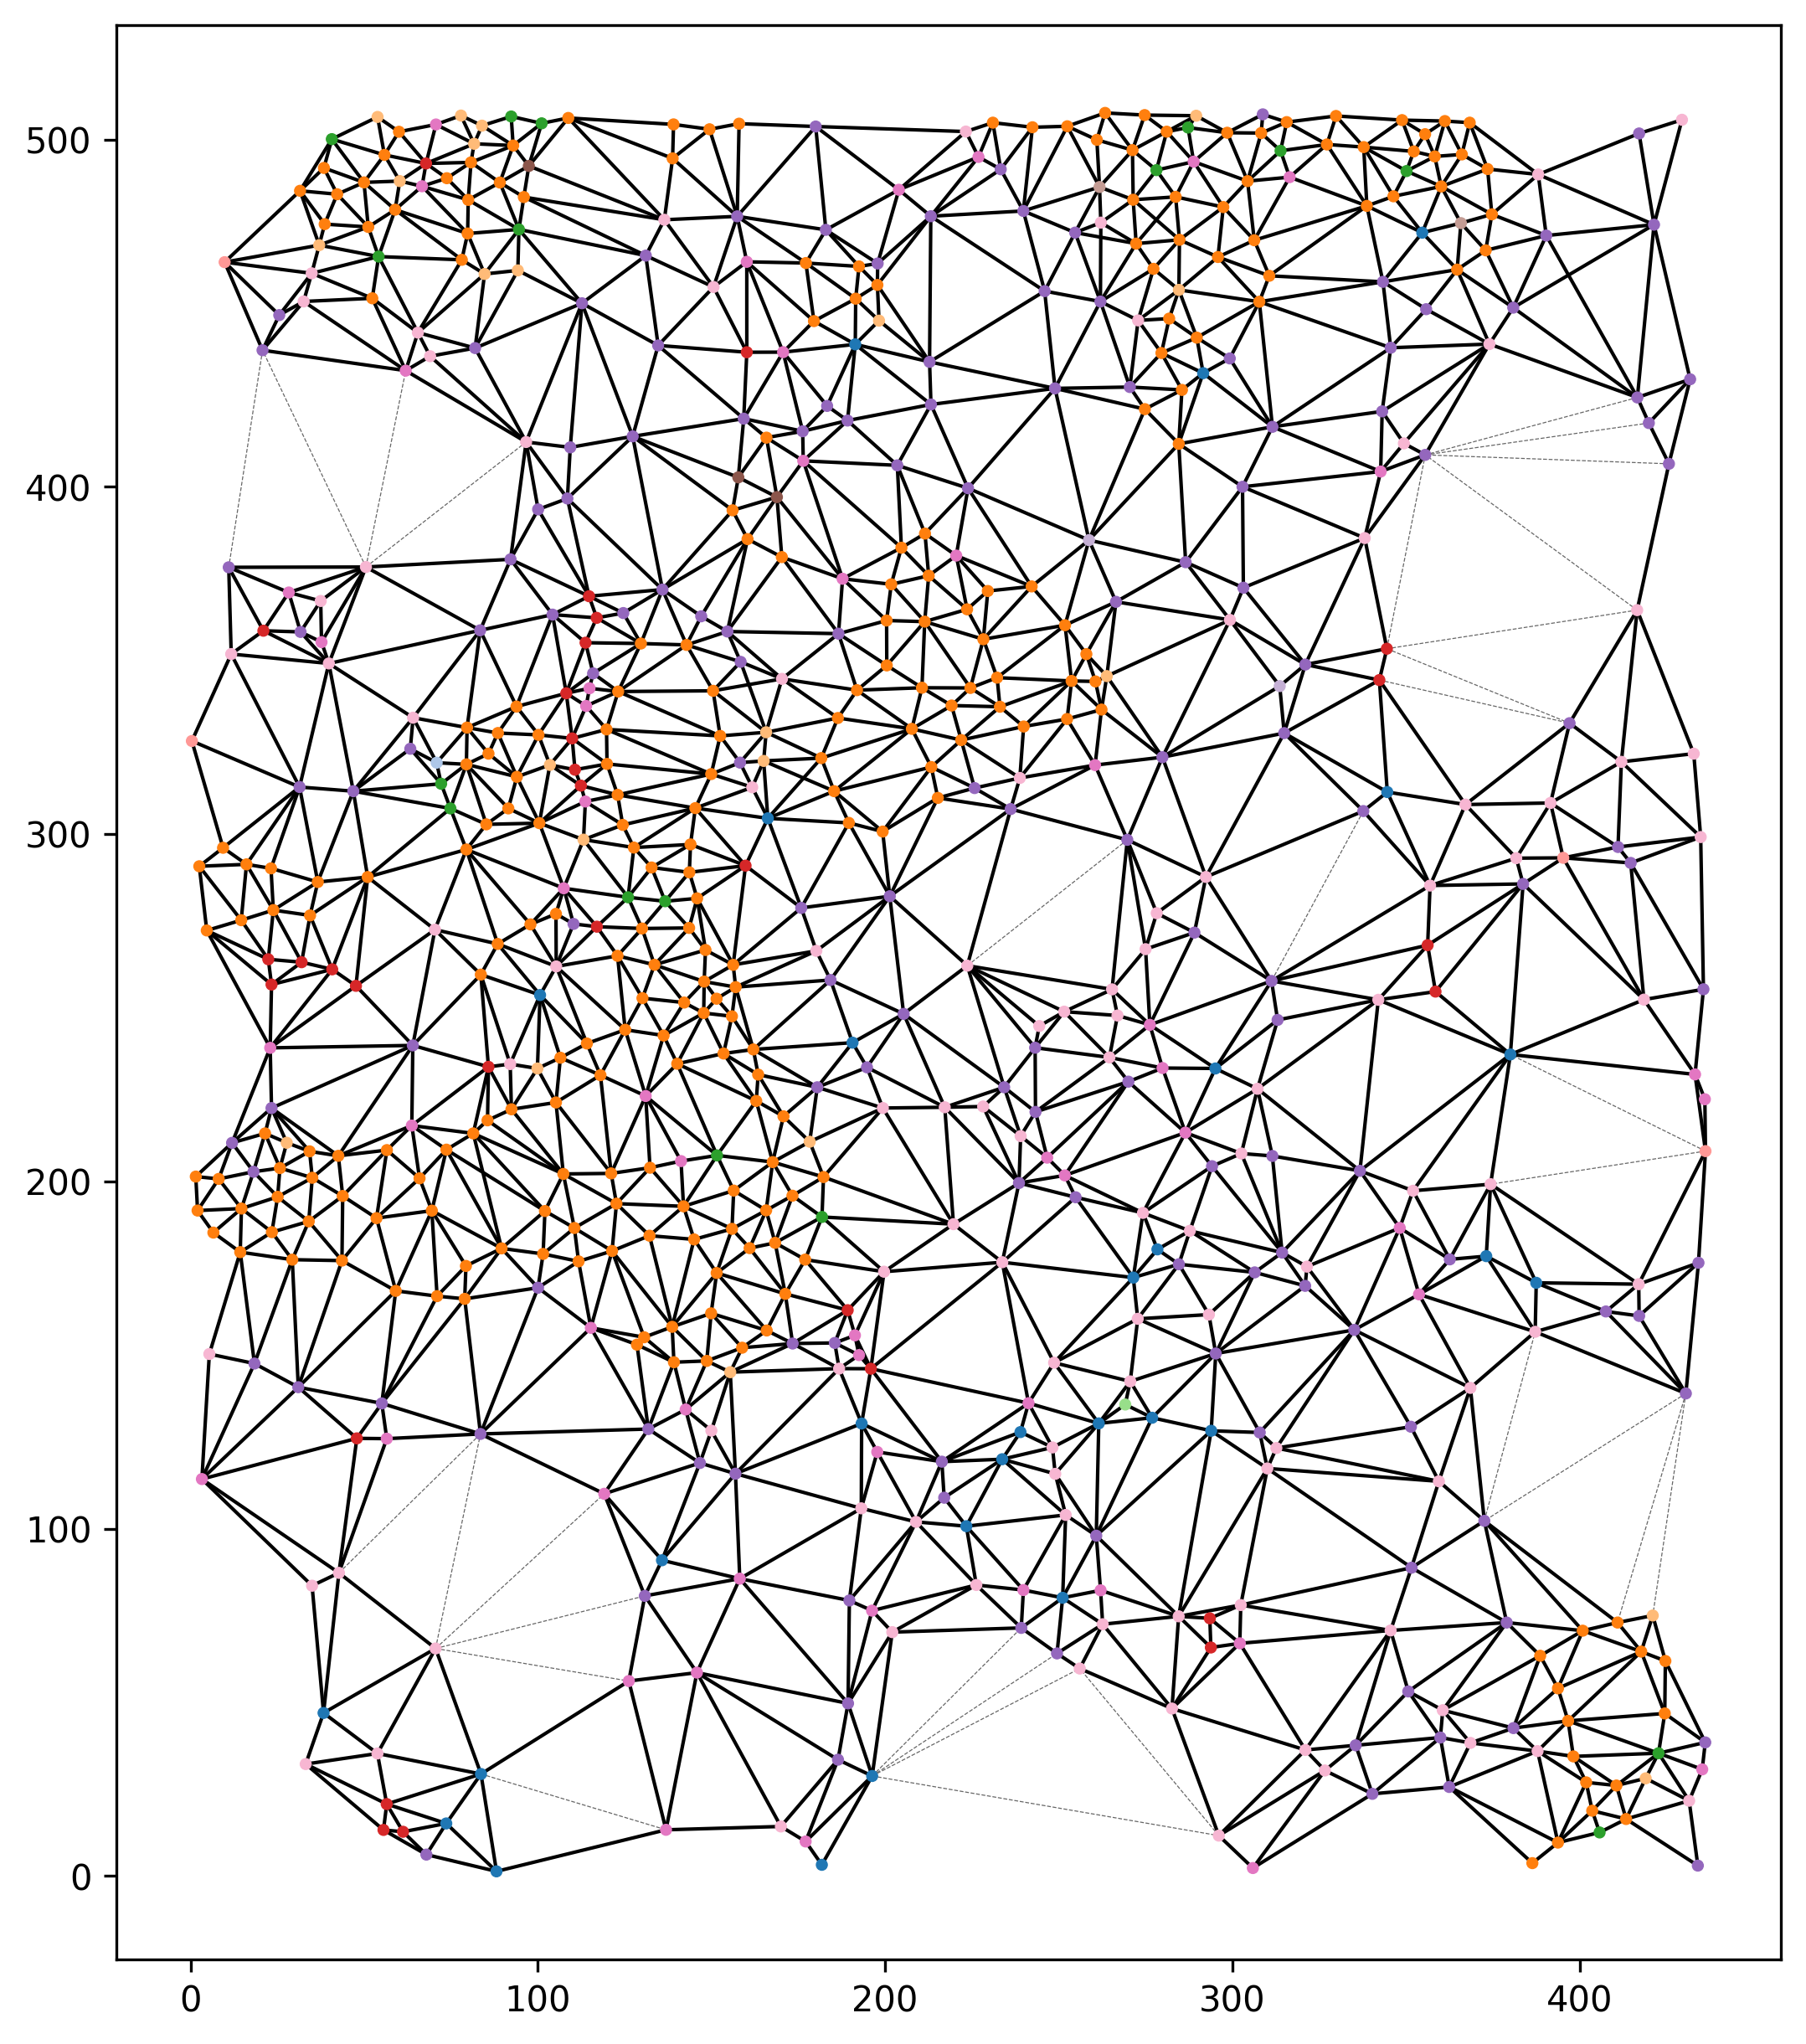

In [6]:
from IPython.display import Image 
pil_img = Image(filename=graph_img_output)
display(pil_img)

<br/><br/><br/><br/>

------------
### Step 2: Construct `CellularGraphDataset`

`CellularGraphDataset` will be the major data container used in model training and evaluation. This object also handles all the featurization, subgraph sampling, and other necessary functionalities for SPACE-GM.

We previously saved all regions as networkx graphs, now we initialize the dataset object using these graph files

In [4]:
dataset_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/example_data_bodenmiller_zurich"
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'graph',  # os.path.join(dataset_root, "graph") is the folder where we saved nx graphs
    'processed_folder_name': 'tg_graph',  # processed dataset files will be stored here
    'node_features': ["cell_type", "biomarker_expression", "neighborhood_composition", "center_coord"],  # There are all the cellular features that we want the dataset to compute
    'edge_features': ["edge_type", "distance"],  # edge (cell pair) features
    'subgraph_size': 3,  # indicating we want to sample 3-hop subgraphs from these regions (for training/inference), this is a core parameter for SPACE-GM.
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,
}

feature_kwargs = {
    "biomarker_expression_process_method": "linear",
    "biomarker_expression_lower_bound": 0,
    "biomarker_expression_upper_bound": 18,
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

dataset = spacegm.CellularGraphDataset(dataset_root, **dataset_kwargs)

<br/><br/><br/><br/>

The full cellular graph for each region in the dataset can be accessed using the class method `get_full`:

In [6]:
i = 0
dataset.get_full(i)

Data(x=[1180, 60], edge_index=[2, 6894], edge_attr=[6894, 2], num_nodes=1180, region_id='ZTMA208_slide_10_By10x4', component_id=0)

<br/><br/><br/><br/>

And the n-hop (n=3 in this example) subgraph of region `i` around its center node `j` can be accessed using the class method `get_subgraph`: 

In [7]:
i = 0
j = 1000
dataset.get_subgraph(i, j)

Data(x=[41, 60], edge_index=[2, 202], edge_attr=[202, 2], center_node_index=34, original_center_node=1000, num_nodes=41, region_id='ZTMA208_slide_10_By10x4', component_id=0)

<br/><br/><br/><br/>

By default, indexing the dataset object will yield an n-hop subgraph around a randomly picked center node (see class method `pick_center`) in the specified region:

In [9]:
dataset[0]

Data(x=[50, 60], edge_index=[2, 254], edge_attr=[254, 2], center_node_index=33, original_center_node=854, num_nodes=50, region_id='ZTMA208_slide_10_By10x4', component_id=0)

<br/><br/><br/><br/>

There is also a quick plotting functions for subgraphs: `plot_subgraph`

(244.59280746991737, 414.0244764807006, 189.6051531489294, 359.03682215971264)

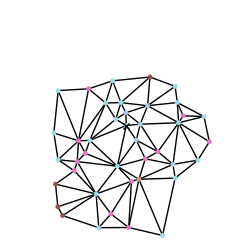

In [12]:
i = 0
j = 1000

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

<br/><br/><br/><br/>

During training, due to the high throughput of data streaming, on-the-fly calculation of subgraph might be slow. To speed up data loading, we will save all subgraphs to chunk files first and load them during training/inference.

In [13]:
dataset.save_all_subgraphs_to_chunk()

In [14]:
import time

dataset.clear_cache()
dataset.set_subgraph_source('on-the-fly') # Can also be set through the `subgraph_source` argument
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Sampling 5000 subgraphs on-the-fly took %.2f seconds" % (t1 - t0))

dataset.clear_cache()
dataset.set_subgraph_source('chunk_save')  
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Loading 5000 subgraphs from chunk save took %.2f seconds" % (t1 - t0))


Sampling 5000 subgraphs on-the-fly took 9.33 seconds
Loading 5000 subgraphs from chunk save took 6.57 seconds


<br/><br/><br/><br/>

Transformers will be used to mask features, add node-level and graph-level tasks, etc.

In [10]:
transformers = [
    # `AddCenterCellType` will add `node_y` attribute to the subgraph for node-level prediction task
    # In this task we will mask the cell type of the center cell and use its neighborhood to predict the true cell type
    spacegm.AddCenterCellType(dataset),
    # `AddGraphLabel` will add `graph_y` and `graph_w` attributes to the subgraph for graph-level prediction task
    spacegm.AddGraphLabel(graph_label_file, tasks=['ERStatus', 'PRStatus']),
    # Transformer `FeatureMask` will zero mask all feature items not included in its argument
    # In this tutorial we perform training/inference using cell types and center cell's size feature
    spacegm.FeatureMask(dataset, use_center_node_features=['cell_type'], use_neighbor_node_features=['cell_type']),
]

dataset.set_transforms([])  # No transformation
d1 = dataset[0]

dataset.set_transforms(transformers)
d2 = dataset[0]

<br/><br/>
`d1.x` has a full feature matrix, while `d2.x` only has the first column (for cell types) populated, except for its center cell, which has an additional feature of size.

(`d1` and `d2` are different subgraphs due to the random sampling)

In [11]:
print("\nFeatures of `d1`")
display(d1.x)
print("\nFeatures of `d2`")
display(d2.x)
print("\nCenter cell feature of `d2`")
display(d2.x[d2.center_node_index])


Features of `d1`


tensor([[2.0000e+00, 4.4268e-02, 4.0063e-02,  ..., 0.0000e+00, 2.4685e+02,
         2.0385e+02],
        [2.0000e+00, 5.8943e-02, 9.3711e-02,  ..., 0.0000e+00, 2.5244e+02,
         2.0989e+02],
        [3.0000e+00, 3.1354e-02, 5.3960e-02,  ..., 0.0000e+00, 2.5507e+02,
         1.4580e+02],
        ...,
        [4.0000e+00, 2.4264e-02, 2.8099e-02,  ..., 0.0000e+00, 2.6423e+02,
         1.7790e+02],
        [4.0000e+00, 5.0807e-02, 1.5322e-02,  ..., 0.0000e+00, 2.5540e+02,
         1.8960e+02],
        [2.0000e+00, 5.3625e-02, 1.7905e-01,  ..., 0.0000e+00, 2.5777e+02,
         1.9495e+02]], dtype=torch.float64)


Features of `d2`


tensor([[ 6.,  0.,  0.,  ...,  0.,  0.,  0.],
        [12.,  0.,  0.,  ...,  0.,  0.,  0.],
        [20.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 3.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  ...,  0.,  0.,  0.],
        [20.,  0.,  0.,  ...,  0.,  0.,  0.]], dtype=torch.float64)


Center cell feature of `d2`


tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=torch.float64)

<br/><br/>

Note that d2 has additional attributes: `d2.node_y`, `d2.graph_y`, `d2.graph_w`

In [12]:
display(d1)
display(d2)

Data(x=[41, 60], edge_index=[2, 200], edge_attr=[200, 2], center_node_index=32, original_center_node=1112, num_nodes=41, region_id='ZTMA208_slide_10_By10x4', component_id=0)

Data(x=[40, 60], edge_index=[2, 194], edge_attr=[194, 2], center_node_index=29, original_center_node=519, num_nodes=40, region_id='ZTMA208_slide_10_By10x4', component_id=0, node_y=[1], graph_y=[1, 2], graph_w=[1, 2])

<br/><br/><br/><br/>

------

### Step 3 Initialize a Graph Neural Network (GNN)

Now we construct a graph neural network for predicting `survival_status`.

The graph neural network will be composed of 3 parts:
1. The backbone GNN with specified number of graph convolutional layers
2. A node task prediction module if there are node-level tasks defined, this module will be constructed based on the node embedding of the center node
3. A graph task prediction module if there are graph-level tasks defined, this module will be constructed based on the graph-pooled embedding of all the nodes

In [13]:
len(dataset.cell_type_mapping) + 1

24

In [14]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,  # same number of layers as number of hops in the subgraphs
    'num_node_type': len(dataset.cell_type_mapping) + 1,  # number of embeddings for different cell types (plus one placeholder cell type)
    'num_feat': dataset[0].x.shape[1] - 1,  # exclude the cell type column
    'emb_dim': 512, 
    'num_node_tasks': len(dataset.cell_type_mapping),  # A multi-class classification task: predicting center cell type
    'num_graph_tasks': 2,  # a binary classification task
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cpu'

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(24, 512)
    (feat_embedding): Linear(in_features=59, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=23, bias=True)
  )
)

<br/><br/><br/><br/>

------

### Step 4 Train the GNN

GNNs in SPACE-GM are trained using n-hop subgraphs, see `data.SubgraphSampler` for details.

In this tutorial we specified one node-level task (predicting center cell type) and one graph-level task (predicting binary survival status), each task will have a specific loss function.


In [22]:
train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  # Weight of graph task loss relative to node task loss
    'num_iterations': 50,  # In this demo we only train for 50 iterations/batches

    # Loss functions
    'node_task_loss_fn': nn.CrossEntropyLoss(),
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),    

    # Evaluation during training
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,  # Evaluate the model every 10 iterations
}

<br/><br/>

On-the-fly evaluation of model performances is included in the training pipeline:

In [23]:
evaluate_kwargs = {
    'node_task_evaluate_fn': spacegm.inference.cell_type_prediction_evaluate_fn,
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_node_task_evaluate_fn': spacegm.inference.full_graph_cell_type_prediction_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 10,
    'score_file': os.path.join(model_save_root, 'GIN-example.txt'),
    'model_folder': os.path.join(model_save_root, 'GIN-example'),
}
train_kwargs.update(evaluate_kwargs)

<br/><br/>

Run training:

In [23]:
model = spacegm.train.train_subgraph(
    model, 
    dataset,
    device,
    # train_inds=[0, 1, 2, 3],
    # valid_inds=[0, 1, 2, 3],
    **train_kwargs)

Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40


<br/><br/>

Evaluation metrics during training are saved in the specified score file:

In [24]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Eval-Subgraph,Train,node-score,0.133,0.242,0.430,0.542,graph-score,0.846,0.689

Eval-Full-Graph,Train,node-score,0.161,0.318,0.586,0.695,graph-score,0.913,0.727

Eval-Subgraph,Train,node-score,0.179,0.236,0.578,0.698,graph-score,0.838,0.646

Eval-Full-Graph,Train,node-score,0.157,0.202,0.511,0.626,graph-score,0.904,0.697

Eval-Subgraph,Train,node-score,0.324,0.480,0.698,0.797,graph-score,0.884,0.703

Eval-Full-Graph,Train,node-score,0.296,0.413,0.580,0.734,graph-score,0.918,0.770

Eval-Subgraph,Train,node-score,0.354,0.472,0.667,0.808,graph-score,0.867,0.723

Eval-Full-Graph,Train,node-score,0.343,0.452,0.647,0.783,graph-score,0.909,0.761



<br/><br/>

Intermediate model weights are saved in the specified model folder:

In [25]:
print(os.listdir(evaluate_kwargs['model_folder']))

['model_save_0.pt', 'model_save_2.pt', 'model_save_3.pt', 'model_save_1.pt']


<br/><br/><br/><br/>

------

### Step 5 Evaluate the GNN

As GNNs are trained using subgraphs, there are two ways for evaluation (especially for graph-level tasks):

- Sample subgraphs and calculate metrics by treating each subgraph as an independent data point;
- Iterate over all the subgraphs (cells) of each region and calculate metrics, for graph-level tasks treat the aggregated (average) prediction from a region as an independent data point;

This is also reflected in the on-the-fly evaluation above: `spacegm.train.evaluate_by_sampling_subgraphs` and `spacegm.train.evaluate_by_full_graph`.

Here we demonstrate the two types of evaluation:

In [27]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device, print_progress=True)

# Aggregated (average) predictions of each region
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))

spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

A208_slide_10_By10x5, average prediction: 0.500
On region ZTMA208_slide_10_By10x6, average prediction: 0.500
On region ZTMA208_slide_10_By10x7, average prediction: 0.500
On region ZTMA208_slide_10_By10x8, average prediction: 0.499
On region ZTMA208_slide_11_By5x8, average prediction: 0.500
On region ZTMA208_slide_11_By6x1, average prediction: 0.500
On region ZTMA208_slide_11_By6x2, average prediction: 0.500
On region ZTMA208_slide_11_By6x3, average prediction: 0.500
On region ZTMA208_slide_11_By6x4, average prediction: 0.500
On region ZTMA208_slide_12_Ay13x7, average prediction: 0.500
On region ZTMA208_slide_12_Ay13x8, average prediction: 0.500
On region ZTMA208_slide_12_Ay14x2, average prediction: 0.500
On region ZTMA208_slide_12_Ay14x3, average prediction: 0.501
On region ZTMA208_slide_13_Cy9x1, average prediction: 0.500
On region ZTMA208_slide_13_Cy9x2, average prediction: 0.500
On region ZTMA208_slide_13_Cy9x3, average prediction: 0.500
On region ZTMA208_slide_13_Cy9x4, average pre

[0.48330928330928324, 0.4226281352235551]

In [28]:
# Evaluation by sampling subgraphs
node_preds, node_labels, graph_preds, graph_ys, graph_ws = spacegm.inference.collect_predict_by_random_sample(
    model, dataset, device, num_eval_iterations=50)
spacegm.inference.graph_classification_evaluate_fn(graph_preds, graph_ys, graph_ws)

GRAPH [0.4779956078402411, 0.4492355914155881]


[0.4779956078402411, 0.4492355914155881]